# DCIP Century Reference Model Synthetic Example

This notebook does the following:
1. Loads the inversion result from the century dataset
2. Generates synthetic data from it, using the same mesh
3. Compare the synthetic data with original dataset
4. Runs an inversion on the synthetic data with PyGIMLi

References:
- Mutton, A. J. (2000). The application of geophysics during evaluation of the Century zinc deposit. Geophysics, 65(6), 1946–1960. https://doi.org/10.1190/1.1444878

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pygimli
import cofi

## 1. Load reference model from the century dataset

In [2]:
def read_ref_model():
    dc_model = np.loadtxt("century_dc_model.txt")
    ip_model = -np.loadtxt("century_ip_model.txt") * 0.7 / 1000
    ref_model_complex = pygimli.utils.complex.toComplex(dc_model, ip_model)
    ref_mesh = pygimli.meshtools.readMeshIO("century_mesh.vtk")
    return ref_model_complex, ref_mesh

ref_model_complex, ref_mesh = read_ref_model()

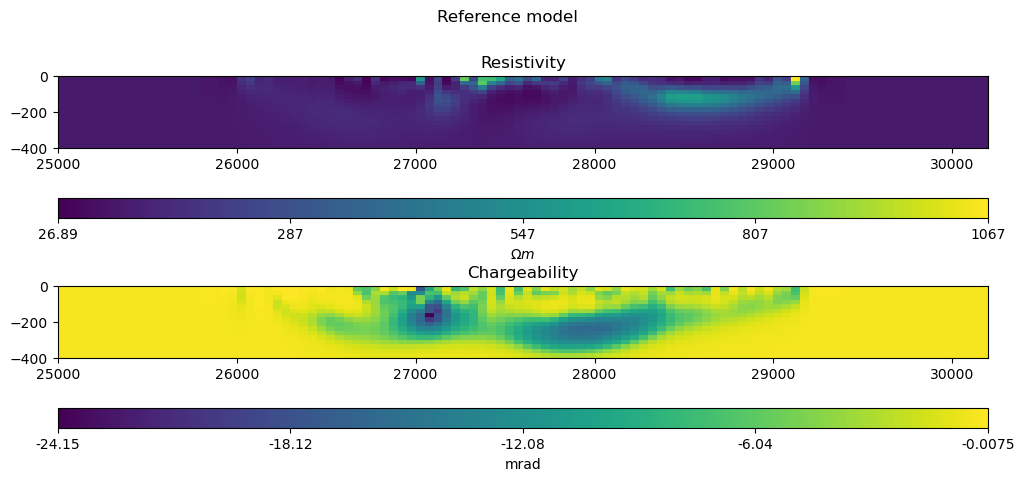

In [3]:
x_inv_start = 26000 - 1000
x_inv_stop = 29200 + 1000
y_inv_start = -400
y_inv_stop = 0

def plot_model(mesh, model_vec, title):
    fig, axes = plt.subplots(2, 1,figsize=(12,5))
    pygimli.show(mesh, data=np.abs(model_vec), label=r"$\Omega m$", ax=axes[0])
    axes[0].set_xlim(x_inv_start, x_inv_stop)
    axes[0].set_ylim(y_inv_start, y_inv_stop)
    axes[0].set_title("Resistivity")
    pygimli.show(mesh, data=np.arctan2(np.imag(model_vec), np.real(model_vec)) * 1000, label=r"mrad", ax=axes[1])
    axes[1].set_xlim(x_inv_start, x_inv_stop)
    axes[1].set_ylim(y_inv_start, y_inv_stop)
    axes[1].set_title("Chargeability")
    fig.suptitle(title)

plot_model(ref_mesh, ref_model_complex, "Reference model")

## 2. Generate synthetic data from loaded model

We will need to download the preprocessed dataset first. This notebook [century_data_preprocessing.ipynb](century_data_preprocessing.ipynb) contains the code for data preprocessing.

In [4]:
dcip_data = np.loadtxt("century_dcip_data.txt")

In [5]:
a_locs = dcip_data[:,0]
b_locs = dcip_data[:,1]
m_locs = dcip_data[:,2]
n_locs = dcip_data[:,3]
dc_obs = dcip_data[:,4]
dc_err = dcip_data[:,5]
ip_obs = dcip_data[:,6]*0.7   # https://gpg.geosci.xyz/content/induced_polarization/induced_polarization_data.html
ip_err = dcip_data[:,7]*0.7
geo_factors = dcip_data[:,8]

location_start = np.min(a_locs)
location_stop = np.max(n_locs)
location_interval = m_locs[1] - m_locs[0]
location_num = int((location_stop - location_start) / location_interval + 1)

location_start, location_stop, location_interval, location_num

(26000.0, 29200.0, 100.0, 33)

In [6]:
def data_to_complex(rhoa, phia):
    return rhoa * np.exp(1j * phia)

def data_from_complex(data_complex):
    return np.abs(data_complex), np.arctan2(data_complex.imag, data_complex.real)

In [7]:
def survey_scheme(start=0, stop=50, num=51, schemeName="dd"):
    # --- create empty data container object ---
    pg_data = pygimli.DataContainerERT()
    # create sensor locations
    for sensor in np.linspace(location_start, location_stop, location_num):
        pg_data.createSensor((sensor, 0.0, 0.0))
    # --- add indices for data points ---
    locs_sources = np.vstack((a_locs, b_locs)).T
    locs_receivers = np.vstack((m_locs, n_locs)).T
    for i in range(len(locs_sources)):
        src = locs_sources[i]
        src_idx = (src - location_start) / location_interval
        rec = locs_receivers[i]
        rec_idx = (rec - location_start) / location_interval
        pg_data.createFourPointData(i, src_idx[0], src_idx[1], rec_idx[0], rec_idx[1])
    # --- create geometric factor k ---
    pg_data["k"] = pygimli.physics.ert.createGeometricFactors(pg_data, numerical=True)
    return pg_data

scheme = survey_scheme()

16/11/22 - 16:10:51 - pyGIMLi - INFO - Cache /home/jiawen/opt/mambaforge/envs/cofi_env/lib/python3.10/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (1.1s x 3): /home/jiawen/.cache/pygimli/18014163601855319623


In [8]:
def forward_oprt(mesh, scheme):
    fop = pygimli.physics.ert.ERTModelling(sr=False, verbose=False)
    fop.setComplex(True)
    fop.setData(scheme)
    fop.setMesh(mesh, ignoreRegionManager=True)
    return fop

fwd_oprt = forward_oprt(ref_mesh, scheme)

In [9]:
def foward_simulate(fop, model_complex):
    model_real = pygimli.utils.squeezeComplex(model_complex)
    data_synth = fop.response(model_real)
    data_synth_complex = pygimli.utils.toComplex(data_synth)
    data_synth_log_complex = np.log(data_synth_complex)
    return data_synth_complex, data_synth_log_complex

data_synth_complex, data_synth_log_complex = foward_simulate(fwd_oprt, ref_model_complex)

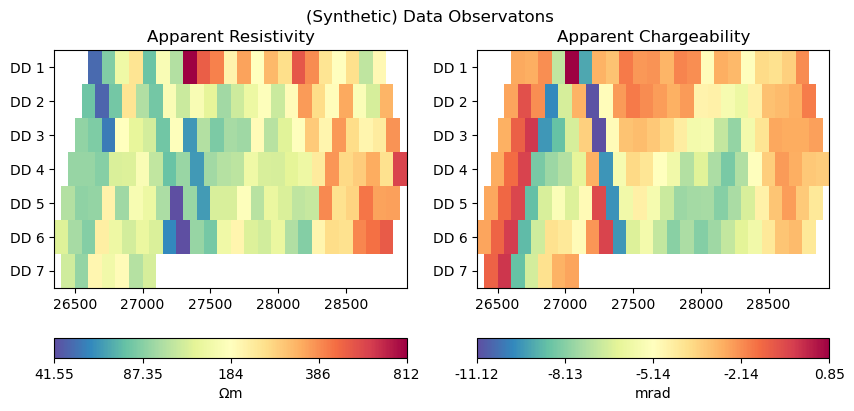

In [10]:
def plot_data(pg_data, data, title):
    fig, axes = plt.subplots(1,2,figsize=(10,4))
    pygimli.physics.ert.showERTData(pg_data, vals=np.real(data), label=r"$\Omega$m", ax=axes[0])
    axes[0].set_title("Apparent Resistivity")
    pygimli.physics.ert.showERTData(pg_data, vals=np.arctan2(np.imag(data), np.real(data))*1000, label=r"mrad", ax=axes[1])
    axes[1].set_title("Apparent Chargeability")
    fig.suptitle(title)

plot_data(scheme, data_synth_complex, "(Synthetic) Data Observatons")

## 3. Compare the synthetic data with original dataset

### 3.1. Load the actual data observations

In [11]:
dcip_data = np.loadtxt("century_dcip_data.txt")

In [12]:
a_locs = dcip_data[:,0]
b_locs = dcip_data[:,1]
m_locs = dcip_data[:,2]
n_locs = dcip_data[:,3]
dc_obs = dcip_data[:,4]
dc_err = dcip_data[:,5]
ip_obs = dcip_data[:,6]*0.7   # https://gpg.geosci.xyz/content/induced_polarization/induced_polarization_data.html
ip_err = dcip_data[:,7]*0.7
geo_factors = dcip_data[:,8]

location_start = np.min(a_locs)
location_stop = np.max(n_locs)
location_interval = m_locs[1] - m_locs[0]
location_num = int((location_stop - location_start) / location_interval + 1)

location_start, location_stop, location_interval, location_num

(26000.0, 29200.0, 100.0, 33)

In [13]:
# PyGIMLi DataContainerERT
def pygimli_data(a_locs, b_locs, m_locs, n_locs, dc_obs, dc_err, ip_obs, ip_err):
    # --- create empty data container object ---
    pg_data = pygimli.DataContainerERT()
    # create sensor locations
    for sensor in np.linspace(location_start, location_stop, location_num):
        pg_data.createSensor((sensor, 0.0, 0.0))
    # --- add indices for data points ---
    locs_sources = np.vstack((a_locs, b_locs)).T
    locs_receivers = np.vstack((m_locs, n_locs)).T
    for i in range(len(locs_sources)):
        src = locs_sources[i]
        src_idx = (src - location_start) / location_interval
        rec = locs_receivers[i]
        rec_idx = (rec - location_start) / location_interval
        pg_data.createFourPointData(i, src_idx[0], src_idx[1], rec_idx[0], rec_idx[1])
    # --- fill in the observed data and error estimation ---
    pg_data["rhoa"] = dc_obs
    pg_data["err"] = dc_err
    pg_data["phia"] = -ip_obs/1000.     # to make me happy CHECKME
    pg_data["iperr"] = -ip_err/1000.
    # --- create geometric factor k ---
    pg_data["k"] = pygimli.physics.ert.createGeometricFactors(pg_data, numerical=True)
    # --- generate data vals and diag vals of covariance inv matrix in log complex space ---
    data_complex = data_to_complex(pg_data["rhoa"].array(), pg_data["phia"].array())
    # data_complex = pg_data["rhoa"].array() * np.exp(1j * pg_data["phia"].array())
    data_complex_log = np.log(data_complex)
    dc_err_cov_log_inv = 1 / np.log(pg_data["err"]**2)
    ip_err_cov_log_inv = 1 / np.log(pg_data["iperr"]**2)
    data_cov_inv_complex_log = data_to_complex(dc_err_cov_log_inv, ip_err_cov_log_inv)
    # data_cov_inv_complex_log = dc_err_cov_log_inv * np.exp(1j * ip_err_cov_log_inv)
    return pg_data, data_complex_log, data_cov_inv_complex_log

In [14]:
pg_data, data_complex_log, data_cov_inv_complex_log = pygimli_data(a_locs, b_locs, m_locs, n_locs, dc_obs, dc_err, ip_obs, ip_err)
pg_data

16/11/22 - 16:10:53 - pyGIMLi - INFO - Cache /home/jiawen/opt/mambaforge/envs/cofi_env/lib/python3.10/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (7.4s x 5): /home/jiawen/.cache/pygimli/14296407956158401844


Data: Sensors: 33 data: 151, nonzero entries: ['a', 'b', 'err', 'iperr', 'k', 'm', 'n', 'phia', 'rhoa', 'valid']

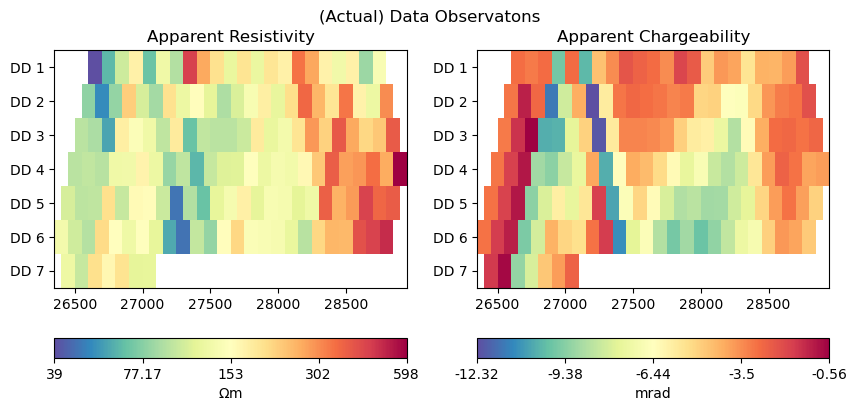

In [15]:
plot_data(pg_data, np.exp(data_complex_log), "(Actual) Data Observatons")

## 4. Run inversion on synthetic data

### 4.1. Create inversion mesh

We should use a separate mesh to do inversion.

### 4.2. Regularization setting

In [16]:
def reg_matrix(fwd_oprt, mesh):
    region_manager = fwd_oprt.regionManager()
    region_manager.setConstraintType(2)
    region_manager.setMesh(mesh)
    Wm = pygimli.matrix.SparseMapMatrix()
    region_manager.fillConstraints(Wm)
    Wm = pygimli.utils.sparseMatrix2coo(Wm)
    return Wm

Wm = reg_matrix(fwd_oprt, ref_mesh)

### 4.3. Create starting model

In [17]:
def starting_model(data, inv_mesh, val=None):
    start_model = np.ones(inv_mesh.cellCount()) * pygimli.utils.complex.toComplex(80, -0.01 / 1000)
    start_model_log = np.log(start_model)
    start_model_log_real = pygimli.utils.squeezeComplex(start_model_log)
    return start_model, start_model_log, start_model_log_real

start_model, start_model_log, start_model_log_real = starting_model(pg_data, ref_mesh)

### 4.4. Utility functions

In [18]:
# Utility Functions (additional)

def _ensure_numpy(model):
    if "torch.Tensor" in str(type(model)):
        model = model.cpu().detach().numpy()
    return model

# accepts model in log complex space -> produces y in log complex space
def get_response(model_log, fop):
    model = np.exp(model_log)
    model = _ensure_numpy(model)
    model_re_im = pygimli.utils.squeezeComplex(model)
    synth = np.array(fop.response(model_re_im))
    return np.log(pygimli.utils.toComplex(synth))

# accepts model in log complex space -> produces Jac in log-log complex space
def get_jacobian(model_log, fop):
    model = np.exp(model_log)
    model = _ensure_numpy(model)
    model_re_im = pygimli.utils.squeezeComplex(model)
    J_block = fop.createJacobian(model_re_im)
    J_re = np.array(J_block.mat(0))
    J_im = np.array(J_block.mat(1))
    J = J_re + 1j * J_im
    y_synth_log = get_response(model_log, fop)
    J_loglog = J / np.exp(y_synth_log[:,np.newaxis]) * model[np.newaxis,:]
    return J_loglog

# accepts model/data in log complex space -> produces residuals in log complex space
def get_residuals(model_log, data_log, fop):
    y_synth_log = get_response(model_log, fop)
    return data_log - y_synth_log

# accepts model in log real space -> produces objective value in log real space
def get_objective(model_log_real, data_log, fop, lamda, Wm):
    # convert model_log_real into complex numbers
    model_log = pygimli.utils.complex.toComplex(model_log_real)
    # calculate data misfit
    res = get_residuals(model_log, data_log, fop)
    data_misfit = res.T.dot(res)
    # calculate regularization term
    weighted_model_log = Wm.dot(model_log)
    reg = lamda * weighted_model_log.T.dot(weighted_model_log)
    # sum up
    result = np.abs(data_misfit + reg)
    return result

# accepts model in log real space -> produces gradient vector in log real space
def get_gradient(model_log_real, data_log, fop, lamda, Wm):
    # convert model_log_real into complex numbers
    model_log = pygimli.utils.complex.toComplex(model_log_real)
    # calculate gradient for data misfit
    res = get_residuals(model_log, data_log, fop)
    jac = get_jacobian(model_log, fop)
    data_misfit_grad = - jac.conj().T.dot(res)
    # calculate gradient for regularization term
    reg_grad = lamda * Wm.T.dot(Wm).dot(model_log)
    # sum up
    grad_complex = data_misfit_grad + reg_grad
    grad_real = pygimli.utils.squeezeComplex(grad_complex)
    return grad_real

# accepts model in log real space -> produces hessian matrix in log real space
def get_hessian(model_log_real, data_log, fop, lamda, Wm):
    # convert model_log_real into complex numbers
    nparams = int(len(model_log_real) // 2)
    model_log = pygimli.utils.complex.toComplex(model_log_real)
    # calculate hessian for data misfit
    res = get_residuals(model_log, data_log, fop)
    jac = get_jacobian(model_log, fop)
    data_misfit_hessian = jac.conj().T.dot(jac)
    # calculate hessian for regularization term
    reg_hessian = lamda * Wm.T.dot(Wm)
    # sum up
    hessian_complex = data_misfit_hessian + reg_hessian
    hessian_real = np.zeros((2*nparams, 2*nparams))
    hessian_real[:nparams,:nparams] = np.real(hessian_complex)
    hessian_real[:nparams,nparams:] = -np.imag(hessian_complex)
    hessian_real[nparams:,:nparams] = np.imag(hessian_complex)
    hessian_real[nparams:,nparams:] = np.real(hessian_complex)
    return hessian_real

# accepts model in log real space -> produces model in normal complex space
def post_process(model_log_real):
    nparams = int(model_log_real.shape[0]/2)
    return np.exp(model_log_real[:nparams] + 1j * model_log_real[nparams:])

### 4.5. Define CoFI BaseProblem, InversionOptions, Inversion and run

In [19]:
# hyperparameters
lamda=0.0001

# CoFI - define BaseProblem
dcip_problem = cofi.BaseProblem()
dcip_problem.name = "DC-IP defined through PyGIMLi"
dcip_problem.set_objective(get_objective, args=[data_synth_log_complex, fwd_oprt, lamda, Wm])
dcip_problem.set_gradient(get_gradient, args=[data_synth_log_complex, fwd_oprt, lamda, Wm])
dcip_problem.set_hessian(get_hessian, args=[data_synth_log_complex, fwd_oprt, lamda, Wm])
dcip_problem.set_initial_model(start_model_log_real)

In [20]:
dcip_problem.objective(start_model_log_real)

16/11/22 - 16:10:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/11/22 - 16:10:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


115.0121220889963

In [21]:
class CallbackFunction:
    def __init__(self):
        self.x = None
        self.i = 0

    def __call__(self, xk):
        print(f"Iteration #{self.i+1}")
        if self.x is not None:
            print(f"  model change: {np.linalg.norm(xk - self.x)}")
        print(f"  objective value: {dcip_problem.objective(xk)}")
        self.x = xk
        self.i += 1

inv_options_scipy = cofi.InversionOptions()
inv_options_scipy.set_tool("scipy.optimize.minimize")
inv_options_scipy.set_params(method="L-BFGS-B", options={"maxiter":10}, callback=CallbackFunction())

In [22]:
inv = cofi.Inversion(dcip_problem, inv_options_scipy)
inv_result = inv.run()
print(f"\nSolver message: {inv_result.message}")

/home/jiawen/opt/mambaforge/envs/cofi_env/lib/python3.10/site-packages/scipy/optimize/_minimize.py:555: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,
/home/jiawen/opt/mambaforge/envs/cofi_env/lib/python3.10/site-packages/scipy/optimize/_minimize.py:561: RuntimeWarning: Method L-BFGS-B does not use Hessian-vector product information (hessp).
  warn('Method %s does not use Hessian-vector product '


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	
*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	
Iteration #1
  objective value: 102.4785085862711
*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	
Iteration #2
  model change: 5.351466794061602
  objective value: 60.951129805778
*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	
Iteration #3
  model change: 6.996055217214944
  objective value: 26.14339560709909
*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	
*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	
Iteration #4
  model change: 2.798248780712588
  objective value: 16.771416208513756
***

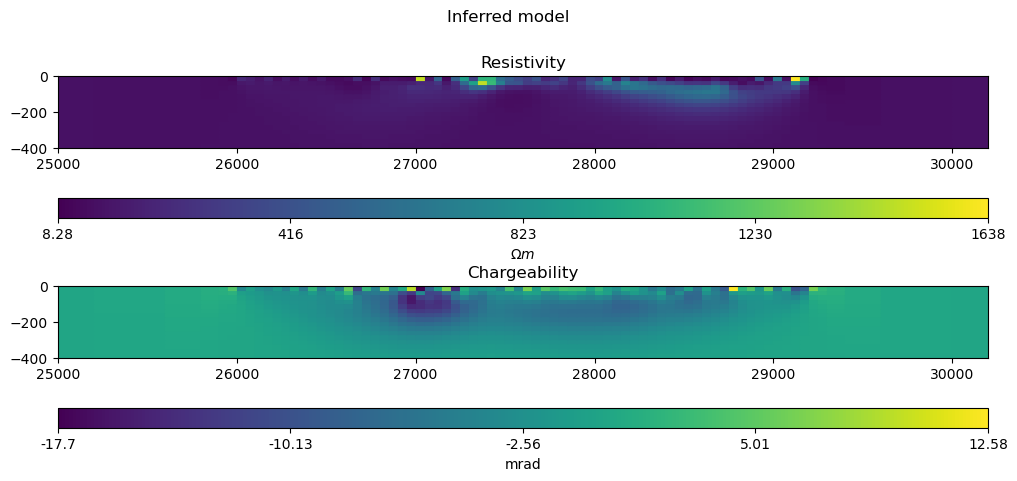

In [23]:
model_log_real = inv_result.model
model_log_complex = pygimli.utils.complex.toComplex(model_log_real)
model_complex = np.exp(model_log_complex)
plot_model(ref_mesh, model_complex, "Inferred model")

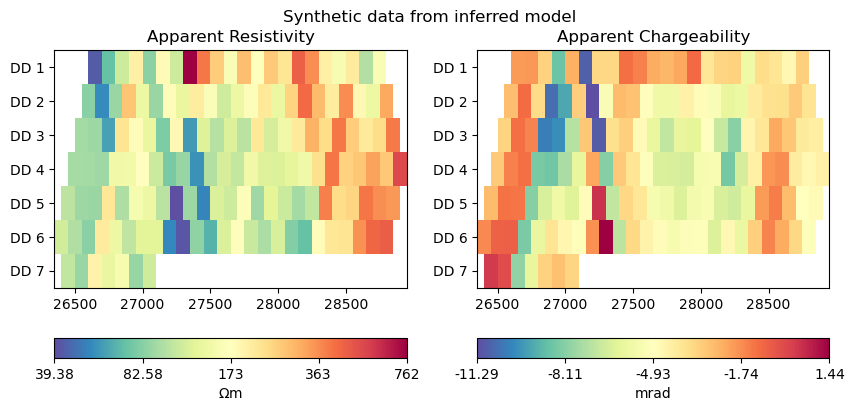

In [24]:
data_log_complex = get_response(model_log_complex, fwd_oprt)
data_complex = np.exp(data_log_complex)
plot_data(pg_data, data_complex, "Synthetic data from inferred model")

## 5. Run inversion on real data

In [29]:
# hyperparameters
lamda=0.0001

# CoFI - define BaseProblem
dcip_problem_realobs = cofi.BaseProblem()
dcip_problem_realobs.name = "DC-IP defined through PyGIMLi"
dcip_problem_realobs.set_objective(get_objective, args=[data_complex_log, fwd_oprt, lamda, Wm])
dcip_problem_realobs.set_gradient(get_gradient, args=[data_complex_log, fwd_oprt, lamda, Wm])
dcip_problem_realobs.set_hessian(get_hessian, args=[data_complex_log, fwd_oprt, lamda, Wm])
dcip_problem_realobs.set_initial_model(start_model_log_real)

In [30]:
inv_options_scipy2 = cofi.InversionOptions()
inv_options_scipy2.set_tool("scipy.optimize.minimize")
inv_options_scipy2.set_params(method="L-BFGS-B", options={"maxiter":10}, callback=CallbackFunction())

In [32]:
inv2 = cofi.Inversion(dcip_problem_realobs, inv_options_scipy2)
inv_result2 = inv2.run()
print(f"\nSolver message: {inv_result2.message}")

*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	
*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	
Iteration #1
  objective value: 102.45204749669848
*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	
Iteration #2
  model change: 5.46490825606323
  objective value: 59.10905391887828
*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	
Iteration #3
  model change: 7.100111477137702
  objective value: 24.442915399554717
*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	
*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	
Iteration #4
  model change: 2.808388573978172
  objective value: 15.278768289053096


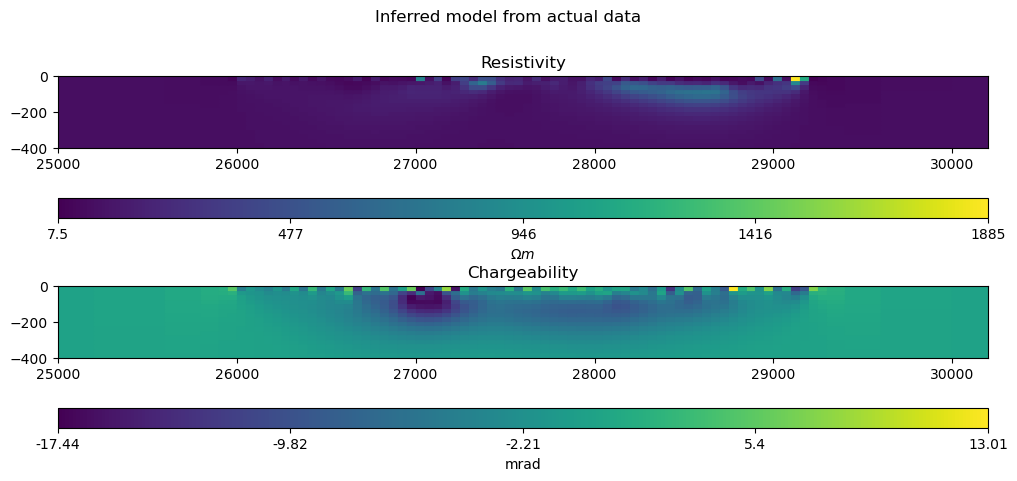

In [37]:
model_log_real2 = inv_result2.model
model_log_complex2 = pygimli.utils.complex.toComplex(model_log_real2)
model_complex2 = np.exp(model_log_complex2)
plot_model(ref_mesh, model_complex2, "Inferred model from actual data")

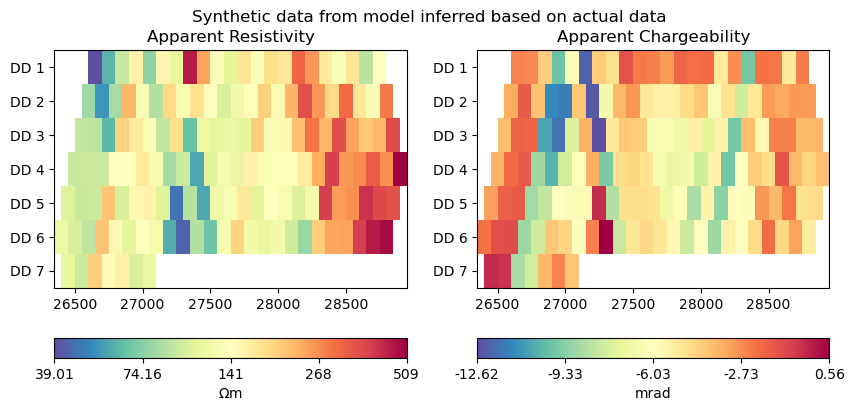

In [38]:
data_log_complex2 = get_response(model_log_complex2, fwd_oprt)
data_complex2 = np.exp(data_log_complex2)
plot_data(pg_data, data_complex2, "Synthetic data from model inferred based on actual data")

---
## Watermark

In [25]:
watermark_list = ["cofi", "numpy", "scipy", "pygimli", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.2.dev21
numpy 1.21.6
scipy 1.9.1
pygimli 1.2.6
matplotlib 3.5.3
